In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/snips-dataset/train_data.csv
/kaggle/input/snips-dataset/validate_data.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# import pandas as pd
# import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
# Путь к файлу CSV
train_data_path = "/kaggle/input/snips-dataset/train_data.csv"
validate_data_path = "/kaggle/input/snips-dataset/validate_data.csv"

# Чтение данных из CSV-файлов
train_data = pd.read_csv(train_data_path)
validate_data = pd.read_csv(validate_data_path)

# Вывод первых 5 строк каждого DataFrame
print("Train data:")
print(train_data.head())
print("\nValidate data:")
print(validate_data.head())

Train data:
                       text       entity              intent
0  Please help me find the           NaN  SearchCreativeWork
1        Bloom: Remix Album  object_name  SearchCreativeWork
2                                    NaN  SearchCreativeWork
3                      song  object_type  SearchCreativeWork
4                         .          NaN  SearchCreativeWork

Validate data:
                  text       entity              intent
0    Wish to find the           NaN  SearchCreativeWork
1                movie  object_type  SearchCreativeWork
2                 the           NaN  SearchCreativeWork
3           Heart Beat  object_name  SearchCreativeWork
4  Please look up the           NaN  SearchCreativeWork


In [6]:
unique_values_normalized = train_data['intent'].value_counts(normalize=True)
print(unique_values_normalized)

intent
BookRestaurant          0.194746
GetWeather              0.175608
AddToPlaylist           0.157467
PlayMusic               0.149945
SearchCreativeWork      0.139878
SearchScreeningEvent    0.099889
RateBook                0.082467
Name: proportion, dtype: float64


In [7]:
train_data = train_data.drop('entity', axis=1)
validate_data = validate_data.drop('entity', axis=1)

In [8]:
# Удалите строки, где столбец 'column_name' пуст
train_data = train_data.dropna(subset=['text'])
validate_data = validate_data.dropna(subset=['text'])

In [9]:
# Подсчитываем количество примеров для каждого класса
class_counts = train_data['intent'].value_counts()

# Находим класс с наименьшим количеством примеров
min_class = class_counts.idxmin()
min_class_count = class_counts.min()

# Делаем undersampling для всех остальных классов
balanced_data = train_data[train_data['intent'] == min_class]
for intent in class_counts.index:
    if intent != min_class:
        samples = train_data[train_data['intent'] == intent].sample(min_class_count)
        balanced_data = pd.concat([balanced_data, samples], axis=0)

# Теперь в balanced_data примеры каждого класса представлены в одинаковом количестве

In [10]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10437 entries, 10357 to 4011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10437 non-null  object
 1   intent  10437 non-null  object
dtypes: object(2)
memory usage: 244.6+ KB


In [11]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
from torch.nn import CrossEntropyLoss

In [13]:
class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [14]:
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [15]:
from torch import nn
from transformers import DistilBertModel

class CustomDistilBertModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomDistilBertModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[0][:, 0]
        output = self.dropout(pooled_output)
        output = self.fc1(output)
        output = nn.Tanh()(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output



In [16]:
# Преобразование меток в числовой формат
unique_intents = train_data['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in balanced_data['intent']]
test_labels = [intent_mapping[intent] for intent in validate_data['intent']]

In [17]:
# Создание наборов данных PyTorch
max_len = 128
batch_size = 16 #16
train_dataset = IntentClassificationDataset(balanced_data['text'].tolist(), train_labels, tokenizer, max_len)
test_dataset = IntentClassificationDataset(validate_data['text'].tolist(), test_labels, tokenizer, max_len)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
from transformers import DistilBertForSequenceClassification, AdamW
import torch

# Загрузка модели DistilBERT
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_intents))
model = CustomDistilBertModel(num_labels=len(unique_intents))

# Компиляция модели
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# Создание экземпляра класса EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [20]:
# # Замораживаем все параметры модели
# for param in model.parameters():
#     param.requires_grad = False

# # Размораживаем параметры последнего слоя
# for param in model.classifier.parameters():
#     param.requires_grad = True


In [21]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
# from torch.nn import CrossEntropyLoss

Epoch 1: 100%|██████████| 653/653 [01:05<00:00, 10.02it/s]


Epoch: 1, Train Loss: 1.2324


Validation Epoch 1: 100%|██████████| 96/96 [00:03<00:00, 28.88it/s]


Accuracy: 0.5813, Recall: 0.5813, F1-score: 0.5824
Average validation loss:  0.9602067861706018
Validation loss decreased (inf --> 0.960207).  Saving model ...


Epoch 2: 100%|██████████| 653/653 [01:04<00:00, 10.12it/s]


Epoch: 2, Train Loss: 0.8933


Validation Epoch 2: 100%|██████████| 96/96 [00:03<00:00, 28.91it/s]


Accuracy: 0.6270, Recall: 0.6270, F1-score: 0.6278
Average validation loss:  0.9040018183489641
Validation loss decreased (0.960207 --> 0.904002).  Saving model ...


Epoch 3: 100%|██████████| 653/653 [01:04<00:00, 10.12it/s]


Epoch: 3, Train Loss: 0.6696


Validation Epoch 3: 100%|██████████| 96/96 [00:03<00:00, 28.71it/s]


Accuracy: 0.6270, Recall: 0.6270, F1-score: 0.6313
Average validation loss:  0.9639463008691868
EarlyStopping counter: 1 out of 5


Epoch 4: 100%|██████████| 653/653 [01:04<00:00, 10.12it/s]


Epoch: 4, Train Loss: 0.4658


Validation Epoch 4: 100%|██████████| 96/96 [00:03<00:00, 28.96it/s]


Accuracy: 0.6238, Recall: 0.6238, F1-score: 0.6258
Average validation loss:  1.0329791605472565
EarlyStopping counter: 2 out of 5


Epoch 5: 100%|██████████| 653/653 [01:04<00:00, 10.13it/s]


Epoch: 5, Train Loss: 0.3326


Validation Epoch 5: 100%|██████████| 96/96 [00:03<00:00, 29.14it/s]


Accuracy: 0.6225, Recall: 0.6225, F1-score: 0.6253
Average validation loss:  1.156429494265467
EarlyStopping counter: 3 out of 5


Epoch 6: 100%|██████████| 653/653 [01:04<00:00, 10.14it/s]


Epoch: 6, Train Loss: 0.2806


Validation Epoch 6: 100%|██████████| 96/96 [00:03<00:00, 29.02it/s]


Accuracy: 0.6310, Recall: 0.6310, F1-score: 0.6313
Average validation loss:  1.2027456609066576
EarlyStopping counter: 4 out of 5


Epoch 7: 100%|██████████| 653/653 [01:04<00:00, 10.14it/s]


Epoch: 7, Train Loss: 0.2446


Validation Epoch 7: 100%|██████████| 96/96 [00:03<00:00, 29.13it/s]


Accuracy: 0.6166, Recall: 0.6166, F1-score: 0.6163
Average validation loss:  1.3463486457864444
EarlyStopping counter: 5 out of 5
Early stopping


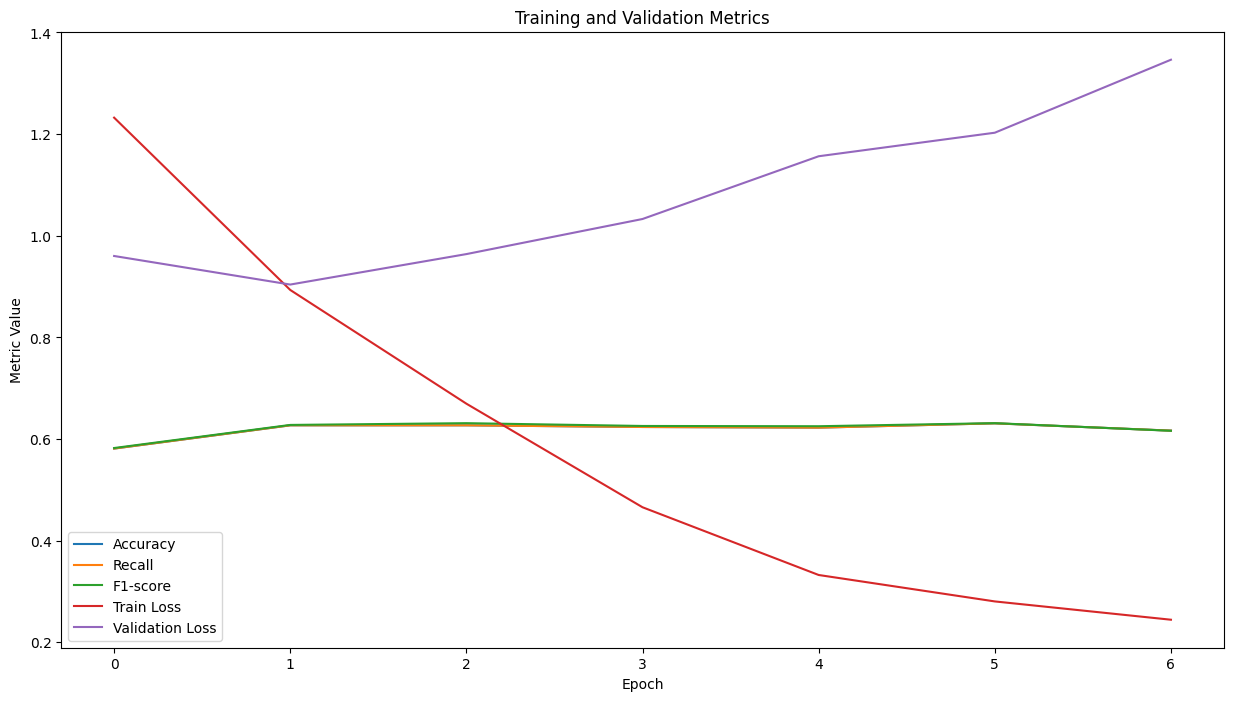

In [22]:
# Количество эпох
epochs = 50

# Списки для хранения значений потерь и метрик на каждой эпохе
loss_values = []
val_loss_values = []  # список для потерь валидации
acc_values = []
rec_values = []
f1_values = []


for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Вызов модели без аргумента labels
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Вычисление потерь
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_data_loader)
    loss_values.append(avg_train_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0
    predictions , true_labels = [], []

    for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
        with torch.no_grad():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Вызов модели без аргумента labels
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Вычисление потерь
            loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
            val_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    acc_values.append(acc)
    rec_values.append(rec)
    f1_values.append(f1)

    print(f"Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    avg_val_loss = val_loss / len(test_data_loader)
    val_loss_values.append(avg_val_loss)  # сохраняем потери валидации
    print('Average validation loss: ', avg_val_loss)

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Построение графиков потерь и метрик
plt.figure(figsize=(15,8))
plt.title("Training and Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")

plt.plot(acc_values, label='Accuracy')
plt.plot(rec_values, label='Recall')
plt.plot(f1_values, label='F1-score')
plt.plot(loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')  # добавляем потери валидации на график
plt.legend()
plt.show()


In [23]:
# new
# from transformers import BertForSequenceClassification
# import matplotlib.pyplot as plt

# # tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# # model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

# # Количество эпох
# epochs = 50

# # Список для хранения значений потерь на каждой эпохе
# loss_values = []

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Вызов модели без аргумента labels
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Вычисление потерь
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_data_loader)
#     loss_values.append(avg_train_loss)

#     print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

#     model.eval()
#     val_loss = 0
#     predictions , true_labels = [], []

#     for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
#         with torch.no_grad():
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             # Вызов модели без аргумента labels
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
#             # Вычисление потерь
#             loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(test_data_loader)
#     print('Average validation loss: ', avg_val_loss)

#     early_stopping(avg_val_loss, model)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

# # Построение графика потерь
# plt.figure(figsize=(15,8))
# plt.title("Training loss")
# plt.xlabel("Batch")
# plt.ylabel("Loss")
# plt.plot(loss_values)
# plt.show()

In [24]:
# old working

# # Обучение модели
# for epoch in range(50):
#     model.train()
#     total_loss = 0
#     progress_bar = tqdm(train_data_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
#     for batch in progress_bar:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Вызов модели
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Вычисление потерь
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
        
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # Обновление шкалы выполнения
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

#     # Расчет среднего значения потерь за эпоху
#     avg_train_loss = total_loss / len(train_data_loader)
#     print('Average training loss: ', avg_train_loss)

#     # Валидация на независимом наборе данных
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch in test_data_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             # Вызов модели
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
#             # Вычисление потерь
#             loss = loss_fct(outputs.view(-1, len(unique_intents)), labels.view(-1))
            
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(test_data_loader)
#     print('Average validation loss: ', avg_val_loss)

#     early_stopping(avg_val_loss, model)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

In [25]:
# Предсказание на тестовых данных
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds)

predicted_labels = [pred.item() for pred in predictions]

In [26]:
# Расчет метрики accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6165904637491836


Accuracy: 0.6087524493794906

In [27]:
# Построение confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(f'Confusion Matrix: \n{cm}')

Confusion Matrix: 
[[ 90  27   3  15  29   6  16]
 [ 15 128   6   2  15  10   2]
 [  3  41 151   1   5  69   9]
 [  9   6   3 136  18   6  50]
 [  9   7   2   2  88   1   0]
 [  1  18  62   7  29 187   5]
 [ 13   9   3  39   9   5 164]]


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

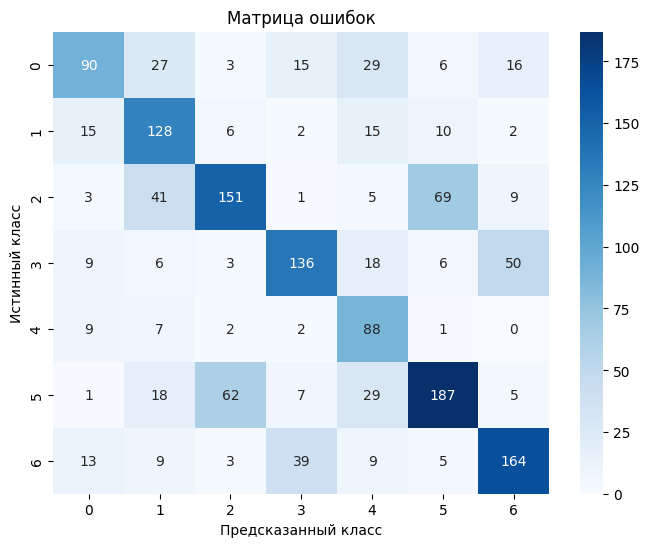

In [29]:
# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(predicted_labels))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()
